In [1]:
import os
import zipfile
import numpy as np
from PIL import Image
from keras.models import Model
import matplotlib.pyplot as plt
from keras.optimizers import Adam
import xml.etree.ElementTree as ET
from keras.callbacks import LearningRateScheduler
from keras.layers import Input, Dense, Conv2D, Reshape, Flatten, concatenate, UpSampling2D

Using TensorFlow backend.


In [2]:
path = 'D:/GitHub Repository/18-GAN'
os.chdir(path)

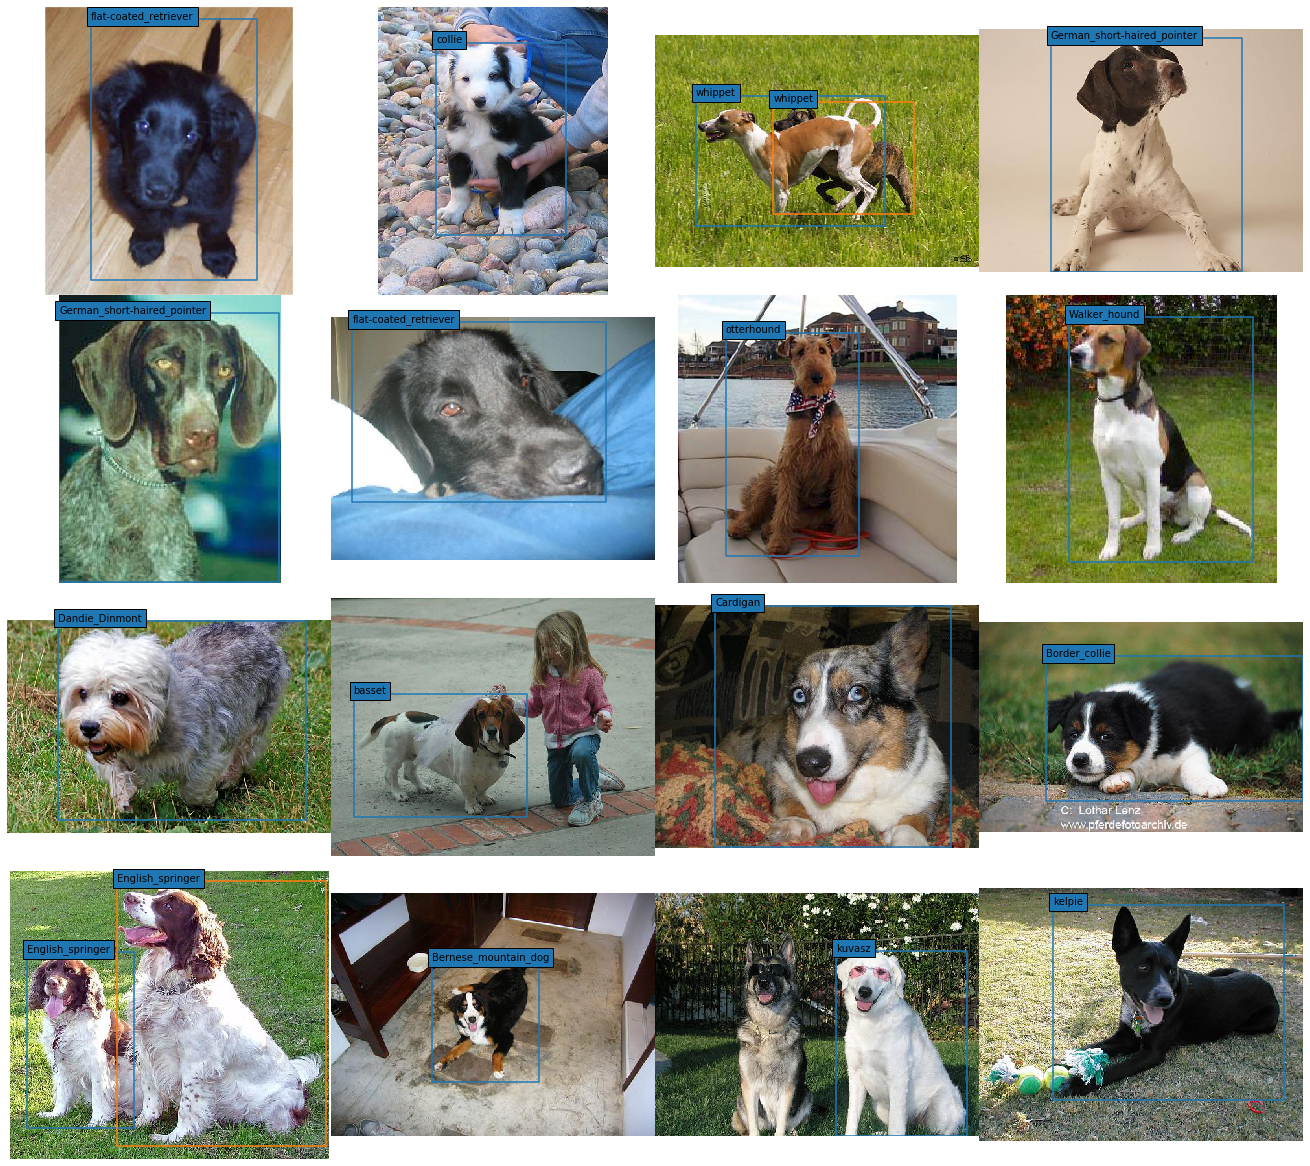

In [3]:
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(18, 16))
    for idx, axis in enumerate(axes.flatten()):
        rand_breed = np.random.choice(os.listdir(path + '/Annotation/'))
        rand_dog = np.random.choice(os.listdir(path + '/Annotation/' + rand_breed))
        rand_image = Image.open(path + '/all-dogs/' + rand_dog + '.jpg')
        tree = ET.parse('./Annotation/' + rand_breed + '/' + rand_dog)
        root = tree.getroot()
        objects = root.findall('object')
        axis.set_axis_off()
        imgplot = axis.imshow(rand_image)
        for o in objects:
            bndbox = o.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            axis.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin])
            axis.text(xmin, ymin, o.find('name').text, bbox={'ec': None})
    plt.tight_layout(pad=0, w_pad=0, h_pad=0)
    plt.show()


In [4]:
    idxIn = 0;
    namesIn = []
    imagesIn = np.zeros((25000, 64, 64, 3))
    breeds = os.listdir(path + '/Annotation/')

    for breed in breeds:
        for dog in os.listdir(path+'/Annotation/'+breed):
            try:
                img = Image.open(path + '/all-dogs/' + dog + '.jpg')
            except:
                continue
            tree = ET.parse('./Annotation/' + breed + '/' + dog)
            root = tree.getroot()
            objects = root.findall('object')
            for o in objects:
                bndbox = o.find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                w = np.min((xmax - xmin, ymax - ymin))
                img = img.crop((xmin, ymin, xmin + w, ymin + w))
                img = img.resize((64, 64), Image.ANTIALIAS)
                img.save('./cropped-images/' + dog + '.png', 'PNG')
                imagesIn[idxIn, :, :, :] = np.asarray(img)
                namesIn.append(breed)
                idxIn += 1

In [7]:
idx = np.arange(idxIn)
np.random.shuffle(idx)
imagesIn = imagesIn[idx, :, :, :]
namesIn = np.array(namesIn)[idx]

In [8]:
    dog = Input((12288,))
    dogName = Input((10000,))
    x = Dense(12288, activation='sigmoid')(dogName)
    x = Reshape((2, 12288, 1))(concatenate([dog, x]))
    x = Conv2D(1, (2, 1), use_bias=False, name='conv')(x)
    discriminated = Flatten()(x)

    discriminator = Model([dog, dogName], discriminated)
    discriminator.get_layer('conv').trainable = False
    discriminator.get_layer('conv').set_weights([np.array([[[[-1.0]]], [[[1.0]]]])])
    discriminator.compile(optimizer='adam', loss='binary_crossentropy')
    discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 10000)        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 12288)        0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 12288)        122892288   input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 24576)        0           input_1[0][0]                    
                                                                 dense_1[0][0]              

In [9]:
    train_y = (imagesIn[:10000, :, :, :] / 255.).reshape((-1, 12288))
    train_X = np.zeros((10000, 10000))
    for i in range(10000):
        train_X[i, i] = 1
    zeros = np.zeros((10000, 12288))

    lr = 0.5
    for k in range(5):
        annealer = LearningRateScheduler(lambda x: lr)
        h = discriminator.fit([zeros, train_X], train_y, epochs=10, batch_size=256, callbacks=[annealer], verbose=0)
        print('Epoch', (k + 1) * 10, '/30 - loss =', h.history['loss'][-1])
        if h.history['loss'][-1] < 0.533: lr = 0.1
    del train_X, train_y, imagesIn

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 10 /30 - loss = 0.5226619347572327
Epoch 20 /30 - loss = 0.5103167541027069
Epoch 30 /30 - loss = 0.5047665615081787
Epoch 40 /30 - loss = 0.5013322680473328
Epoch 50 /30 - loss = 0.4991844488143921


Discriminator Recalls from Memory Dogs


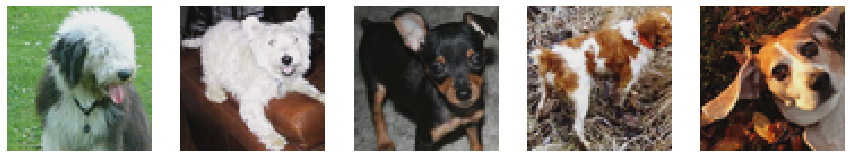

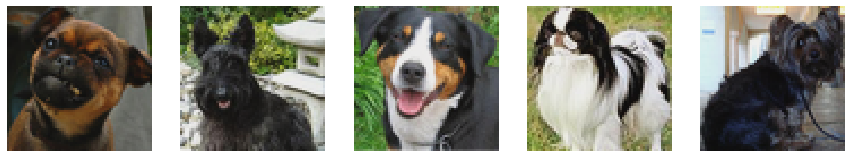

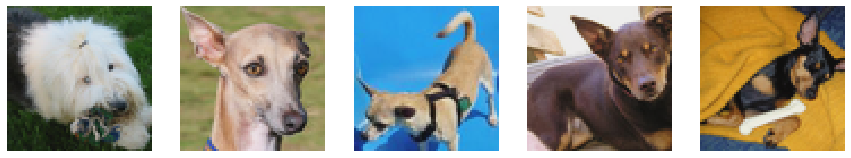

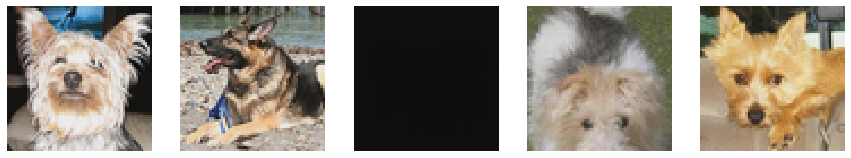

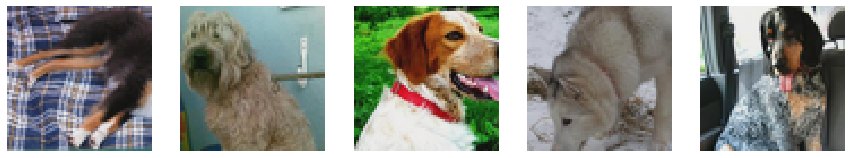

In [10]:
    print('Discriminator Recalls from Memory Dogs')
    zeros = np.zeros((10000, 12288))

    for k in range(5):
        plt.figure(figsize=(15, 3))
        for j in range(5):
            xx = np.zeros((10000))
            xx[np.random.randint(10000)] = 1
            plt.subplot(1, 5, j + 1)
            img = discriminator.predict([zeros[0, :].reshape((-1, 12288)), xx.reshape((-1, 10000))]).reshape(
                (-1, 64, 64, 3))
            img = Image.fromarray((255 * img).astype('uint8').reshape((64, 64, 3)))
            plt.axis('off')
            plt.imshow(img)
        plt.show()

In [11]:
    seed = Input((10000,))
    x = Dense(2048, activation='elu')(seed)
    x = Reshape((8, 8, 32))(x)
    x = Conv2D(128, (3, 3), activation='elu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='elu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(3, (3, 3), activation='linear', padding='same')(x)
    generated = Flatten()(x)
    generator = Model(seed, [generated, Reshape((10000,))(seed)])
    generator.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 10000)        0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2048)         20482048    input_3[0][0]                    
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 8, 8, 32)     0           dense_2[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 8, 128)    36992       reshape_2[0][0]                  
____________________________________________________________________________________________

In [12]:
    discriminator.trainable = False
    gan_input = Input(shape=(10000,))
    x = generator(gan_input)
    gan_output = discriminator(x)

    gan = Model(gan_input, gan_output)
    gan.get_layer('model_1').get_layer('conv').set_weights([np.array([[[[-1]]], [[[255.]]]])])
    gan.compile(optimizer=Adam(5), loss='mean_squared_error')

    gan.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 10000)        0                                            
__________________________________________________________________________________________________
model_2 (Model)                 [(None, 12288), (Non 20612163    input_4[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 12288)        122892290   model_2[1][0]                    
                                                                 model_2[1][1]                    
Total params: 143,504,453
Trainable params: 20,612,163
Non-trainable params: 122,892,290
__________________________________________________________________________________________________


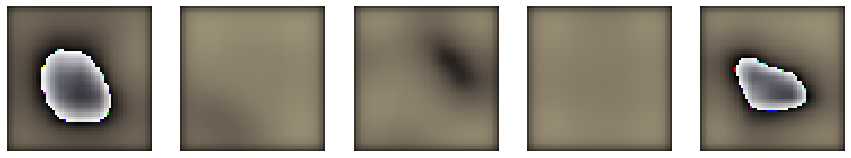

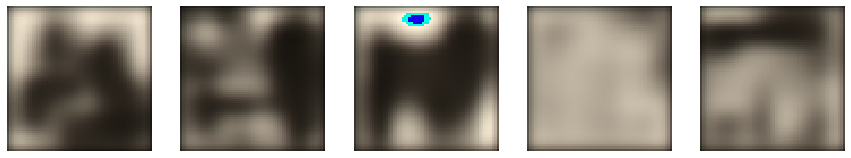

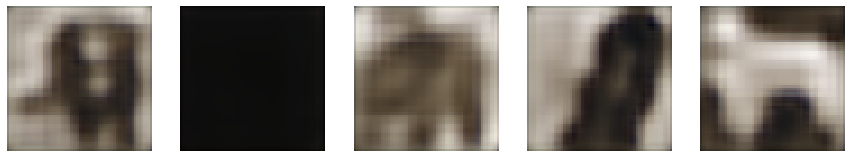

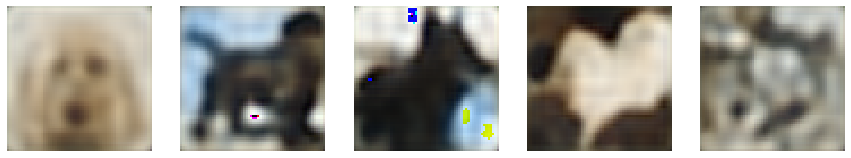

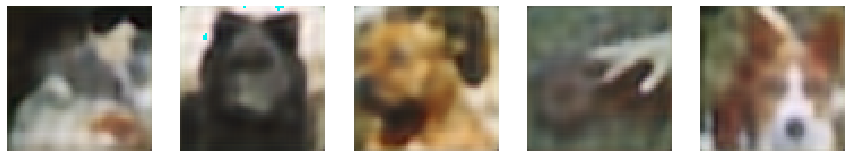

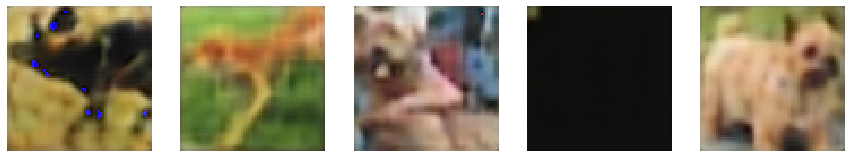

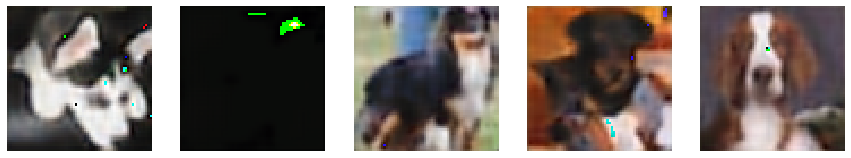

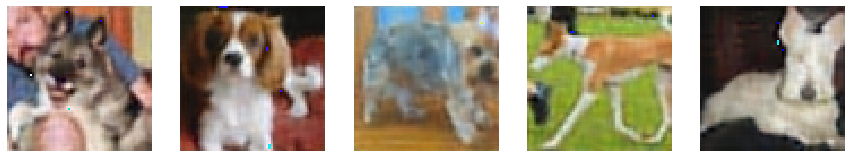

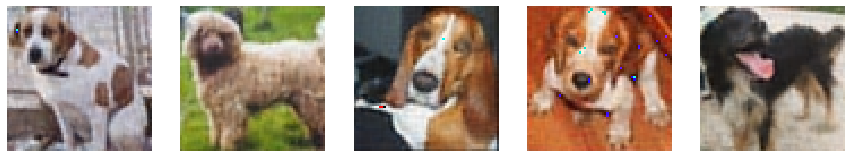

In [13]:
    train = np.zeros((10000, 10000))
    for i in range(10000):
        train[i, i] = 1
    zeros = np.zeros((10000, 12288))
    ep = 1
    iterations = 9
    lr = 0.005

    for k in range(iterations):
        annealer = LearningRateScheduler(lambda x: lr)
        hpi = gan.fit(train, zeros, epochs=ep, batch_size=256, callbacks=[annealer], verbose=0)
        plt.figure(figsize=(15, 3))
        for j in range(5):
            xx = np.zeros((10000))
            xx[np.random.randint(10000)] = 1
            plt.subplot(1, 5, j + 1)
            img = generator.predict(xx.reshape((-1, 10000)))[0].reshape((-1, 64, 64, 3))
            img = Image.fromarray((img).astype('uint8').reshape((64, 64, 3)))
            plt.axis('off')
            plt.imshow(img)
        plt.show()
        ep = ep * 2
        if ep >= 32:
            lr = 0.001
        if ep > 256:
            ep = 256